In [70]:
from scipy.integrate import odeint
from scipy.optimize import fmin
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d ### Might be useful
from scipy.optimize import fsolve
from sympy.solvers import solve
from sympy import Symbol
import pandas as pd
import plotly.express as px

In [2]:
### Utils
def plot_ode_solution(S,I,Z,t,model):
    plt.plot(t,S,label="Susceptible")
    plt.plot(t,I,label="Infected")
    plt.plot(t,Z,label="Recovered")
    plt.title(f"Plot of S-I-Z functions ({model})")
    plt.xlabel("Time (t)")
    plt.ylabel("Number of individuals")
    plt.legend(loc="upper right")
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

In [ ]:
# values={
#     't':[],
#     'Cs':[],
#     'Ci':[],
#     'Cz':[],
#     'S':[],
#     'I':[],
#     'Z':[],
#     'dSdt':[],
#     'dIdt':[],
#     'dZdt':[]
# }

In [3]:
def state_odes_system(x, t, beta, mu, phi, gamma, cs, ci, cz):
    
    # assign each function to a vector element
    s = x[0]
    i = x[1]
    z = x[2]
    
    # C function 
    C = cs(t)*ci(t)/(s*cs(t) + i*ci(t) + z*cz(t) )
    
    # System 
    dSdt = -C*beta*s*i + mu - mu*s
    dIdt = C*beta*s*i + phi*z*i - (gamma+mu)*i  
    dZdt = gamma*i - phi*z*i - mu*z
    
    # global values
    # ### Add values to global variable
    # values['t'] = values['t']+[t]
    # values['Cs'] = values['Cs']+[cs(t)]
    # values['Ci'] = values['Ci']+[ci(t)]
    # values['Cz'] = values['Cz']+[cz(t)]
    # values['S'] = values['S']+[s]
    # values['I'] = values['I']+[i]
    # values['Z'] = values['Z']+[z]
    # values['dSdt'] = values['dSdt']+[dSdt]
    # values['dIdt'] = values['dIdt']+[dIdt]
    # values['dZdt'] = values['dZdt']+[dZdt]

    return [dSdt, dIdt, dZdt]

def solve_odes_system(x0,t, beta, mu, phi, gamma, cs, ci, cz):
    
    """
    Solve the classical system with initial conditions
    """
    
    x = odeint(state_odes_system, x0, t, args=(beta, mu, phi, gamma, cs, ci, cz))

    s = x[:,0]
    i = x[:,1]
    z = x[:,2]
    
    return s,i,z

Cubic polynomial to find optimal $i^*$. For now this is programed with $C^s,C^i,C^z$ being constant functions.

In [64]:
def get_coefficients_cubic(cs,ci,cz,R0,Rmu,Rphi):
    
    ### Returns the coefficients x3,x2,x1,x0 of the cubic polynomial in the notes.
    x_3=(Rphi**2)*(R0) + Rmu*(Rphi**2)*( (ci/cs) -1)
    
    x_2=Rphi*(R0*(1-Rphi) + Rmu*(R0+Rphi))
    x_2= x_2 + Rphi*( Rmu*(1-Rmu)*( (cz/cs) - 1) + Rmu*(1+Rmu)*( (ci/cs) - 1) ) 
    
    x_1= Rmu*(R0*(1-Rphi)  + Rphi*(1-R0)  + Rmu*Rphi )
    x_1= x_1+ Rmu*( (1-Rmu)*( (cz/cs) -1 ) + Rmu*( (ci/cs) -1  )   )
    
    x_0=(Rmu**2)*(1-R0)
    
    return [x_0,x_1,x_2,x_3]

def evaluate_cubic(i,cs,ci,cz,R0,Rmu,Rphi):
    [x_0,x_1,x_2,x_3] = get_coefficients_cubic(cs,ci,cz,R0,Rmu,Rphi)
    return x_3*(i**3) + x_2*(i**2) + x_1*i + x_0

def solve_polynomial(cs,ci,cz,R0,Rmu,Rphi, printt=True):
    
    if printt:
        print(f"""
        R0 = {R0}
        """)
    # Numeric
    #resp=fsolve(evaluate_polynomial, 0, args=(mu,gamma,beta,nu,phi,ci,cs,cz))
    
    # Symbolic
    x = Symbol('x')
    
    resp = solve(evaluate_cubic(x,cs,ci,cz,R0,Rmu,Rphi), x)
    resp = [(float(expr.as_real_imag()[0]), float(expr.as_real_imag()[1]) ) for expr in resp]
    resp = [expr[0] for expr in resp if expr[0]>0 and abs(expr[1])<1e-15]
    
    return resp

Examples

1. Example from *A mathematical model with nonlinear relapse: conditions for a forward-backward bifurcation* (Figure 2).

In [16]:
### Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.009
nu = 0.8
phi = 0.0044

### Variable parameter
kappa=0.8

### R values
R0 = beta*kappa/(mu+gamma)
Rmu = mu/(mu+gamma)
Rphi = phi/(mu+gamma)

### Simulation parameters
t_max=2000
h=t_max/1000
t = np.linspace(0,t_max,int(t_max/h))
x0=[0.85,0.1,0.05]

In [17]:
### C^s, C^i, C^z

def cs1(t):
    return kappa
def ci1(t):
    return kappa
def cz1(t):
    return kappa*(1+nu)

S1,I1,Z1 = solve_odes_system(x0, t, beta, mu, phi, gamma, cs1, ci1, cz1)

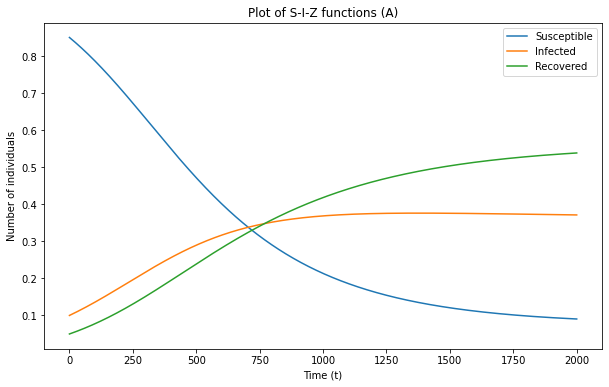

In [18]:
plot_ode_solution(S1,I1,Z1,t,model='A')

Computing Equilibria for kappas took 77.92285585403442 seconds.


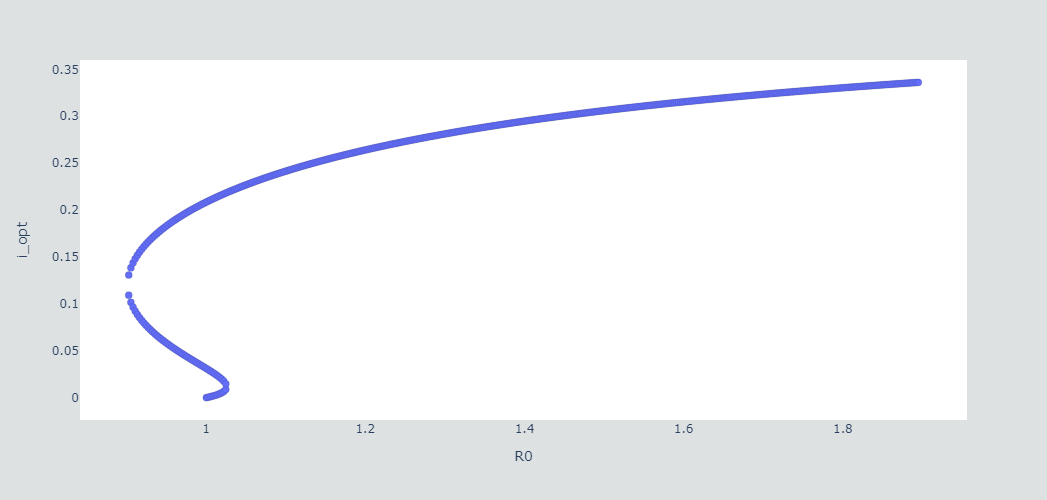

In [ ]:
df_values_plot=pd.DataFrame({
    'R0':[],
    'i_opt':[]
})

kappas = np.linspace(0.0001,0.6,700)

start=time.time()
for kappa in kappas:
    ### R value
    R0 = beta*kappa/(mu+gamma)
    roots=solve_polynomial(kappa,kappa,kappa*(1+nu),R0,Rmu,Rphi, printt=False)
    for root in roots:
        df_values_plot=df_values_plot.append(pd.DataFrame({
            'R0':[R0],
            'i_opt':[root]
        }),ignore_index=True)
end=time.time()
print(f"Computing Equilibria for kappas took {end-start} seconds.")

fig = px.scatter(df_values_plot, x="R0", y="i_opt")
fig.update_traces(marker=dict(size=7, line=dict(width=0.1, color='Black')))
fig.update_layout(paper_bgcolor='#DDE1E2',plot_bgcolor='#FFFFFF',height=500, width=600)
fig.show()

In [85]:
### For our simulations we vary C^s, C^i, C^z ?